In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pickle
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import copy
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
warnings.filterwarnings(action='ignore')
from epftoolbox.evaluation import MAE, sMAPE

C:\Users\csebastian\.conda\envs\BrainEN_v1\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# DNN

In [2]:
df = pd.read_csv(r"Data/df_espana_final.csv")

In [3]:
df['Date'] = pd.to_datetime(df.Date)
df['Simple Date'] = df.Date.dt.strftime("%Y-%m-%d")
df['Hour'] = df.Date.dt.hour

In [4]:
df = df.fillna(0)

In [5]:
df.isna().sum()

Date           0
Price          0
Exogenous 1    0
Exogenous 2    0
Exogenous 3    0
Exogenous 4    0
Simple Date    0
Hour           0
dtype: int64

In [6]:
df

,Date,Price,Exogenous 1,Exogenous 2,Exogenous 3,Exogenous 4,Simple Date,Hour
0,2019-01-02 00:00:00,64.03,24914.0,5795.0,0.0,19.500,2019-01-02,0
1,2019-01-02 01:00:00,61.74,22758.0,6460.0,0.0,24.400,2019-01-02,1
2,2019-01-02 02:00:00,53.00,20772.0,6684.0,0.0,15.200,2019-01-02,2
3,2019-01-02 03:00:00,48.23,19690.0,6957.0,0.0,24.300,2019-01-02,3
4,2019-01-02 04:00:00,47.23,19176.0,7292.0,0.0,6.000,2019-01-02,4
...,...,...,...,...,...,...,...,...
38659,2023-05-31 19:00:00,78.89,25595.5,2325.8,8196.5,1413.275,2023-05-31,19
38660,2023-05-31 20:00:00,85.00,26170.3,2345.5,5498.0,1340.275,2023-05-31,20
38661,2023-05-31 21:00:00,105.00,26918.3,2253.3,1989.3,1021.550,2023-05-31,21
38662,2023-05-31 22:00:00,119.06,27557.3,2265.3,232.8,681.525,2023-05-31,22


In [7]:
df['Exogenous 2'] = df['Exogenous 2'] + df['Exogenous 3'] + df['Exogenous 4']
df = df.drop(['Exogenous 3', 'Exogenous 4'], axis = 1)

In [8]:
df.columns = ['Date', 'Price', 'Exogenous 1', 'Exogenous 2', 'Simple Date', 'Hour']

In [9]:
df

,Date,Price,Exogenous 1,Exogenous 2,Simple Date,Hour
0,2019-01-02 00:00:00,64.03,24914.0,5814.500,2019-01-02,0
1,2019-01-02 01:00:00,61.74,22758.0,6484.400,2019-01-02,1
2,2019-01-02 02:00:00,53.00,20772.0,6699.200,2019-01-02,2
3,2019-01-02 03:00:00,48.23,19690.0,6981.300,2019-01-02,3
4,2019-01-02 04:00:00,47.23,19176.0,7298.000,2019-01-02,4
...,...,...,...,...,...,...
38659,2023-05-31 19:00:00,78.89,25595.5,11935.575,2023-05-31,19
38660,2023-05-31 20:00:00,85.00,26170.3,9183.775,2023-05-31,20
38661,2023-05-31 21:00:00,105.00,26918.3,5264.150,2023-05-31,21
38662,2023-05-31 22:00:00,119.06,27557.3,3179.625,2023-05-31,22


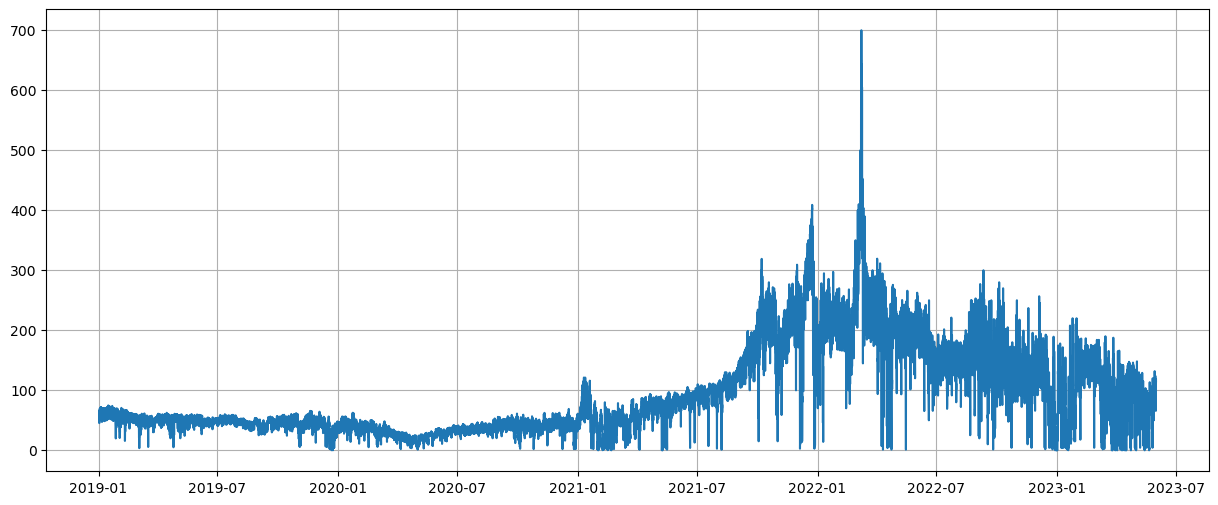

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(df.Date, df.Price)
ax.grid()

In [11]:
df['Price_no_outliers'] = df.Price

Se añaden variables auxiliares

In [12]:
df['Price_24'] = df.Price.shift(24)
df['Price_48'] = df.Price.shift(48)
df['Price_72'] = df.Price.shift(72)
df['Price_96'] = df.Price.shift(96)
df['Price_120'] = df.Price.shift(120)
df['Price_144'] = df.Price.shift(144)
df['Price_168'] = df.Price.shift(168)

In [13]:
df["diff_Price_24"] = df.Price - df.Price_24
df["lower_quantile_diff_Price_24"] = np.nan
df["upper_quantile_diff_Price_24"] = np.nan
for idx in range(len(df)):
    if idx >= 168:
        df_aux = df.loc[idx - 168 : idx - 1]
        df.loc[idx, "lower_quantile_diff_Price_24"] = np.quantile(
            df.diff_Price_24.dropna().to_numpy(), 0.025
        )
        df.loc[idx, "upper_quantile_diff_Price_24"] = np.quantile(
            df.diff_Price_24.dropna().to_numpy(), 0.975
        )

df["outlier"] = 0
df.loc[
    (df.diff_Price_24 < df.lower_quantile_diff_Price_24)
    | (df.diff_Price_24 > df.upper_quantile_diff_Price_24),
    "outlier",
] = 1

# df["Price_no_outliers"] = df["Price"]
col = df.loc[
    :,
    [
        "Price_24",
        "Price_48",
        "Price_72",
        "Price_96",
        "Price_120",
        "Price_144",
        "Price_168",
    ],
]
df["Price_median"] = col.median(axis=1)
df.loc[df.outlier == 1, "Price_no_outliers"] = df[
    df.outlier == 1
].Price_median

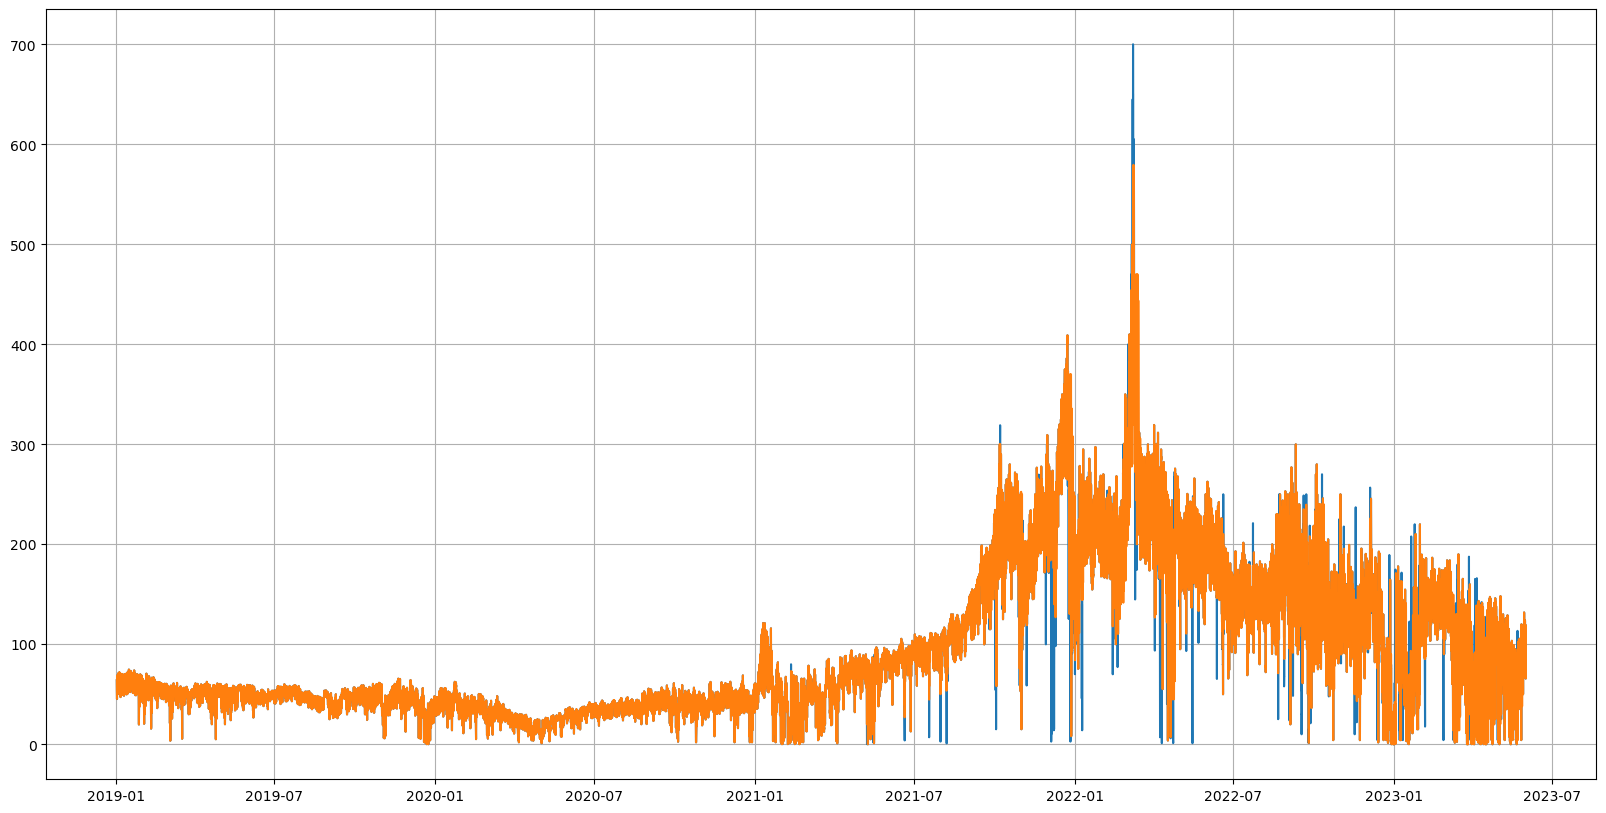

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(df.Date, df.Price)
ax.plot(df.Date, df.Price_no_outliers)
ax.grid()

In [15]:
df = df[['Date', 'Price_no_outliers', 'Exogenous 1', 'Exogenous 2']].rename(columns={'Price_no_outliers':'Price'})

In [16]:
df.index = df.Date

In [17]:
df = df.drop(['Date'], axis = 1)

In [18]:
df_train = df[df.index < dt.datetime(2022, 1, 1)]
df_test = df[df.index >= dt.datetime(2022, 1, 1)]

In [19]:
df_test.columns

Index(['Price', 'Exogenous 1', 'Exogenous 2'], dtype='object')

In [20]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
# real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
# real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [21]:
forecast_dates = forecast.index

In [22]:
df_original = pd.read_csv(r"Data\df_espana_final.csv")

In [23]:
df_original['Date'] = pd.to_datetime(df_original.Date)
df_original['Simple Date'] = df_original.Date.dt.strftime("%Y-%m-%d")
df_original['Hour'] = df_original.Date.dt.hour

In [24]:
df_original = df_original.fillna(0)

In [25]:
df_original.isna().sum()

Date           0
Price          0
Exogenous 1    0
Exogenous 2    0
Exogenous 3    0
Exogenous 4    0
Simple Date    0
Hour           0
dtype: int64

In [26]:
df_original

,Date,Price,Exogenous 1,Exogenous 2,Exogenous 3,Exogenous 4,Simple Date,Hour
0,2019-01-02 00:00:00,64.03,24914.0,5795.0,0.0,19.500,2019-01-02,0
1,2019-01-02 01:00:00,61.74,22758.0,6460.0,0.0,24.400,2019-01-02,1
2,2019-01-02 02:00:00,53.00,20772.0,6684.0,0.0,15.200,2019-01-02,2
3,2019-01-02 03:00:00,48.23,19690.0,6957.0,0.0,24.300,2019-01-02,3
4,2019-01-02 04:00:00,47.23,19176.0,7292.0,0.0,6.000,2019-01-02,4
...,...,...,...,...,...,...,...,...
38659,2023-05-31 19:00:00,78.89,25595.5,2325.8,8196.5,1413.275,2023-05-31,19
38660,2023-05-31 20:00:00,85.00,26170.3,2345.5,5498.0,1340.275,2023-05-31,20
38661,2023-05-31 21:00:00,105.00,26918.3,2253.3,1989.3,1021.550,2023-05-31,21
38662,2023-05-31 22:00:00,119.06,27557.3,2265.3,232.8,681.525,2023-05-31,22


In [27]:
df_original['Exogenous 2'] = df_original['Exogenous 2'] + df_original['Exogenous 3'] + df_original['Exogenous 4']
df_original = df_original.drop(['Exogenous 3', 'Exogenous 4'], axis = 1)

In [28]:
df_original.columns = ['Date', 'Price', 'Exogenous 1', 'Exogenous 2', 'Simple Date', 'Hour']

In [29]:
df_original.index = df_original.Date

In [30]:
df_original = df_original.drop('Date', axis = 1)

In [31]:
df_original = df_original.drop(['Simple Date', 'Hour'], axis = 1)

In [32]:
df_original.columns = ['Price', 'Exogenous 1', 'Exogenous 2']

In [33]:
df_original = df_original[df_original.index >= dt.datetime(2022, 1, 1)]

In [34]:
real_values = df_original[df_original.index >= dt.datetime(2022, 1, 1)].loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [35]:
real_values

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,127.81,145.86,114.90,113.87,97.80,97.80,95.74,97.80,97.80,97.80,...,96.80,97.80,98.52,114.50,149.97,177.22,187.52,189.26,190.81,188.39
2022-01-02,167.26,133.21,115.87,110.52,113.00,115.87,110.52,115.87,129.60,115.87,...,110.52,115.87,109.50,115.87,159.79,194.25,198.00,208.38,209.10,191.36
2022-01-03,178.00,181.50,160.72,154.64,149.86,144.49,148.86,153.77,160.72,189.26,...,142.04,127.38,112.87,126.80,148.49,175.06,180.00,153.77,141.94,114.11
2022-01-04,100.36,125.47,115.55,113.29,105.81,105.00,115.11,153.77,161.03,178.91,...,179.59,163.20,157.30,157.30,163.78,184.94,178.99,156.12,148.65,137.92
2022-01-05,105.00,120.11,105.10,84.50,75.38,79.11,94.79,169.04,206.07,211.13,...,197.34,195.60,200.00,206.07,211.23,225.00,250.34,241.93,218.95,207.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,99.77,96.86,90.00,84.73,81.35,84.85,87.26,90.27,87.29,87.26,...,82.01,66.75,61.71,57.85,58.41,84.85,95.11,100.82,108.21,109.35
2023-05-28,110.00,105.42,100.00,99.37,100.00,100.00,100.00,97.85,90.42,83.06,...,70.47,69.57,54.17,50.00,51.00,55.00,73.28,100.01,109.08,115.38
2023-05-29,107.64,91.84,91.84,84.75,84.75,84.75,85.80,100.00,112.89,110.20,...,84.45,83.85,81.42,80.00,81.00,84.05,84.95,121.00,131.86,129.40


In [36]:
forecast_dates = forecast.index

In [37]:
from epftoolbox.models import hyperparameter_optimizer

In [38]:
df.to_csv("Data/df_espana_dnn_no_outliers.csv")

In [40]:
# Number of layers in DNN
nlayers = 2

# Market under study. If it not one of the standard ones, the file name
# has to be provided, where the file has to be a csv file
dataset = "df_espana_dnn_no_outliers"

# Number of years (a year is 364 days) in the test dataset.
years_test = 1.5

# Optional parameters for selecting the test dataset, if either of them is not provided, 
# the test dataset is built using the years_test parameter. They should either be one of
# the date formats existing in python or a string with the following format
# "%d/%m/%Y %H:%M"
begin_test_date = "01/01/2022 00:00"
end_test_date = "31/05/2023 23:00"

# Boolean that selects whether the validation and training datasets are shuffled
shuffle_train = 1

# Boolean that selects whether a data augmentation technique for DNNs is used
data_augmentation = 0

# Boolean that selects whether we start a new hyperparameter optimization or we restart an existing one
new_hyperopt = 1

# Number of years used in the training dataset for recalibration
calibration_window = 3

# Unique identifier to read the trials file of hyperparameter optimization
experiment_id = 1

# Number of iterations for hyperparameter optimization
max_evals = 100

path_datasets_folder = "./Data/"
path_hyperparameters_folder = "./experimental_files/"

# Check documentation of the hyperparameter_optimizer for each of the function parameters
# In this example, we optimize a model for the PJM market.
# We consider two directories, one for storing the datasets and the other one for the experimental files.
# We start a hyperparameter optimization from scratch. We employ 1500 iterations in hyperopt,
# 2 years of test data, a DNN with 2 hidden layers, a calibration window of 4 years,
# we avoid data augmentation,  and we provide an experiment_id equal to 1
hyperparameter_optimizer(path_datasets_folder=path_datasets_folder, 
                         path_hyperparameters_folder=path_hyperparameters_folder, 
                         new_hyperopt=new_hyperopt, max_evals=max_evals, nlayers=nlayers, dataset=dataset, 
                         years_test=years_test, calibration_window=calibration_window, 
                         shuffle_train=shuffle_train, data_augmentation=0, experiment_id=experiment_id,
                         begin_test_date=begin_test_date, end_test_date=end_test_date)

Test datasets: 2022-01-01 00:00:00 - 2023-05-31 23:00:00


Tested 1/100 iterations.
Best MAE - Validation Dataset
  MAE: 10.9 | sMAPE: 19.28 %

Best MAE - Test Dataset
  MAE: 30.5 | sMAPE: 29.89 %


Tested 2/100 iterations.
Best MAE - Validation Dataset
  MAE: 10.9 | sMAPE: 19.28 %

Best MAE - Test Dataset
  MAE: 30.5 | sMAPE: 29.89 %


Tested 3/100 iterations.
Best MAE - Validation Dataset
  MAE: 10.9 | sMAPE: 19.28 %

Best MAE - Test Dataset
  MAE: 30.5 | sMAPE: 29.89 %


Tested 4/100 iterations.
Best MAE - Validation Dataset
  MAE: 10.9 | sMAPE: 19.28 %

Best MAE - Test Dataset
  MAE: 30.5 | sMAPE: 29.89 %


Tested 5/100 iterations.
Best MAE - Validation Dataset
  MAE: 7.6 | sMAPE: 14.37 %

Best MAE - Test Dataset
  MAE: 24.1 | sMAPE: 24.56 %


Tested 6/100 iterations.
Best MAE - Validation Dataset
  MAE: 7.6 | sMAPE: 14.37 %

Best MAE - Test Dataset
  MAE: 24.1 | sMAPE: 24.56 %


Tested 7/100 iterations.
Best MAE - Validation Dataset
  MAE: 7.6 | sMAPE: 14.37 %

Best MAE - Test Dat



Tested 60/100 iterations.
Best MAE - Validation Dataset
  MAE: 5.9 | sMAPE: 11.72 %

Best MAE - Test Dataset
  MAE: 22.1 | sMAPE: 22.65 %


Tested 61/100 iterations.
Best MAE - Validation Dataset
  MAE: 5.9 | sMAPE: 11.72 %

Best MAE - Test Dataset
  MAE: 22.1 | sMAPE: 22.65 %


Tested 62/100 iterations.
Best MAE - Validation Dataset
  MAE: 5.9 | sMAPE: 11.72 %

Best MAE - Test Dataset
  MAE: 22.1 | sMAPE: 22.65 %


Tested 63/100 iterations.
Best MAE - Validation Dataset
  MAE: 5.9 | sMAPE: 11.72 %

Best MAE - Test Dataset
  MAE: 22.1 | sMAPE: 22.65 %


Tested 64/100 iterations.
Best MAE - Validation Dataset
  MAE: 5.9 | sMAPE: 11.72 %

Best MAE - Test Dataset
  MAE: 22.1 | sMAPE: 22.65 %


Tested 65/100 iterations.
Best MAE - Validation Dataset
  MAE: 5.9 | sMAPE: 11.72 %

Best MAE - Test Dataset
  MAE: 22.1 | sMAPE: 22.65 %


Tested 66/100 iterations.
Best MAE - Validation Dataset
  MAE: 5.9 | sMAPE: 11.72 %

Best MAE - Test Dataset
  MAE: 22.1 | sMAPE: 22.65 %


Tested 67/100 iter

In [39]:
"""
Example for using the DNN model for forecasting prices with daily recalibration
"""

# Author: Jesus Lago

# License: AGPL-3.0 License

import pandas as pd
import numpy as np
import argparse
import os

from epftoolbox.data import read_data
from epftoolbox.evaluation import MAE, sMAPE
from epftoolbox.models import DNN


path_datasets_folder = "./Data/"
path_hyperparameters_folder = "./experimental_files/"
path_recalibration_folder = os.path.join('.', 'Resultados')
path_hyperparameter_folder = os.path.join('.', 'experimental_files')

dataset = "df_espana_dnn_no_outliers"

# Number of years (a year is 364 days) in the test dataset.
years_test = 1.5

# Optional parameters for selecting the test dataset, if either of them is not provided, 
# the test dataset is built using the years_test parameter. They should either be one of
# the date formats existing in python or a string with the following format
# "%d/%m/%Y %H:%M"
begin_test_date = "01/01/2022 00:00"
end_test_date = "31/05/2023 23:00"

# Defining train and testing data
df_train, df_test = read_data(dataset=dataset, years_test=years_test, path=path_datasets_folder,
                              begin_test_date=begin_test_date, end_test_date=end_test_date)

# Defining unique name to save the forecast
forecast_file_name = 'dnn_espana_final_no_outliers.csv'

forecast_file_path = os.path.join(path_recalibration_folder, forecast_file_name)

# # Defining empty forecast array and the real values to be predicted in a more friendly format
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

# # If we are not starting a new recalibration but re-starting an old one, we import the
# # existing files and print metrics 
# if not new_recalibration:
#     # Import existinf forecasting file
#     forecast = pd.read_csv(forecast_file_path, index_col=0)
#     forecast.index = pd.to_datetime(forecast.index)

#     # Reading dates to still be forecasted by checking NaN values
#     forecast_dates = forecast[forecast.isna().any(axis=1)].index

#     # If all the dates to be forecasted have already been forecast, we print information
#     # and exit the script
#     if len(forecast_dates) == 0:

#         mae = np.mean(MAE(forecast.values.squeeze(), real_values.values))
#         smape = np.mean(sMAPE(forecast.values.squeeze(), real_values.values)) * 100
#         print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format('Final metrics', smape, mae))
    
# else:
#     forecast_dates = forecast.index

forecast_dates = forecast.index

nlayers = 2
shuffle_train = 1
data_augmentation = 0
calibration_window = 3
experiment_id = 1

model = DNN(
    experiment_id=experiment_id, path_hyperparameter_folder=path_hyperparameter_folder, nlayers=nlayers, 
    dataset=dataset, years_test=years_test, shuffle_train=shuffle_train, data_augmentation=data_augmentation,
    calibration_window=calibration_window)


# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We extract real prices for current date and set them to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date)

    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

#     # Saving forecast
#     forecast.to_csv(forecast_file_path)

Test datasets: 2022-01-01 00:00:00 - 2023-05-31 23:00:00
2022-01-01 - sMAPE: 45.96%  |  MAE: 72.383
2022-01-02 - sMAPE: 32.94%  |  MAE: 50.030
2022-01-03 - sMAPE: 33.11%  |  MAE: 54.073
2022-01-04 - sMAPE: 27.84%  |  MAE: 45.150
2022-01-05 - sMAPE: 27.37%  |  MAE: 44.094
2022-01-06 - sMAPE: 25.80%  |  MAE: 42.070
2022-01-07 - sMAPE: 23.77%  |  MAE: 39.486
2022-01-08 - sMAPE: 22.00%  |  MAE: 36.996
2022-01-09 - sMAPE: 20.98%  |  MAE: 35.490
2022-01-10 - sMAPE: 19.72%  |  MAE: 33.612
2022-01-11 - sMAPE: 18.48%  |  MAE: 31.764
2022-01-12 - sMAPE: 17.45%  |  MAE: 30.197
2022-01-13 - sMAPE: 16.43%  |  MAE: 28.548
2022-01-14 - sMAPE: 15.91%  |  MAE: 27.920
2022-01-15 - sMAPE: 15.35%  |  MAE: 27.125
2022-01-16 - sMAPE: 14.74%  |  MAE: 26.167
2022-01-17 - sMAPE: 14.18%  |  MAE: 25.354
2022-01-18 - sMAPE: 13.99%  |  MAE: 25.367
2022-01-19 - sMAPE: 13.70%  |  MAE: 25.021
2022-01-20 - sMAPE: 13.45%  |  MAE: 24.646
2022-01-21 - sMAPE: 13.04%  |  MAE: 23.888
2022-01-22 - sMAPE: 12.70%  |  MAE: 23.2

2022-07-10 - sMAPE: 11.37%  |  MAE: 21.960
2022-07-11 - sMAPE: 11.35%  |  MAE: 21.904
2022-07-12 - sMAPE: 11.34%  |  MAE: 21.866
2022-07-13 - sMAPE: 11.32%  |  MAE: 21.828
2022-07-14 - sMAPE: 11.31%  |  MAE: 21.796
2022-07-15 - sMAPE: 11.30%  |  MAE: 21.751
2022-07-16 - sMAPE: 11.30%  |  MAE: 21.716
2022-07-17 - sMAPE: 11.40%  |  MAE: 21.788
2022-07-18 - sMAPE: 11.39%  |  MAE: 21.739
2022-07-19 - sMAPE: 11.38%  |  MAE: 21.687
2022-07-20 - sMAPE: 11.35%  |  MAE: 21.626
2022-07-21 - sMAPE: 11.33%  |  MAE: 21.573
2022-07-22 - sMAPE: 11.32%  |  MAE: 21.517
2022-07-23 - sMAPE: 11.33%  |  MAE: 21.510
2022-07-24 - sMAPE: 11.32%  |  MAE: 21.467
2022-07-25 - sMAPE: 11.32%  |  MAE: 21.434
2022-07-26 - sMAPE: 11.31%  |  MAE: 21.407
2022-07-27 - sMAPE: 11.29%  |  MAE: 21.347
2022-07-28 - sMAPE: 11.29%  |  MAE: 21.328
2022-07-29 - sMAPE: 11.30%  |  MAE: 21.339
2022-07-30 - sMAPE: 11.31%  |  MAE: 21.322
2022-07-31 - sMAPE: 11.34%  |  MAE: 21.319
2022-08-01 - sMAPE: 11.34%  |  MAE: 21.283
2022-08-02 

2023-01-17 - sMAPE: 17.55%  |  MAE: 21.642
2023-01-18 - sMAPE: 17.78%  |  MAE: 21.621
2023-01-19 - sMAPE: 17.83%  |  MAE: 21.592
2023-01-20 - sMAPE: 17.92%  |  MAE: 21.598
2023-01-21 - sMAPE: 17.94%  |  MAE: 21.570
2023-01-22 - sMAPE: 17.99%  |  MAE: 21.559
2023-01-23 - sMAPE: 18.07%  |  MAE: 21.573
2023-01-24 - sMAPE: 18.09%  |  MAE: 21.574
2023-01-25 - sMAPE: 18.12%  |  MAE: 21.589
2023-01-26 - sMAPE: 18.11%  |  MAE: 21.560
2023-01-27 - sMAPE: 18.12%  |  MAE: 21.529
2023-01-28 - sMAPE: 18.12%  |  MAE: 21.490
2023-01-29 - sMAPE: 18.13%  |  MAE: 21.470
2023-01-30 - sMAPE: 18.16%  |  MAE: 21.492
2023-01-31 - sMAPE: 18.18%  |  MAE: 21.507
2023-02-01 - sMAPE: 18.15%  |  MAE: 21.477
2023-02-02 - sMAPE: 18.14%  |  MAE: 21.463
2023-02-03 - sMAPE: 18.11%  |  MAE: 21.428
2023-02-04 - sMAPE: 18.08%  |  MAE: 21.401
2023-02-05 - sMAPE: 18.11%  |  MAE: 21.416
2023-02-06 - sMAPE: 18.08%  |  MAE: 21.385
2023-02-07 - sMAPE: 18.05%  |  MAE: 21.352
2023-02-08 - sMAPE: 18.02%  |  MAE: 21.320
2023-02-09 

In [40]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,192.425476,200.831451,189.558395,186.078461,177.537231,169.039856,168.043091,186.097397,221.204727,225.508041,...,195.845032,189.92804,194.878784,199.297089,214.712036,241.733948,247.07457,246.673798,237.655121,216.87587
2022-01-02,149.860458,145.889404,136.604431,133.362976,130.368591,126.920578,132.816071,146.317596,168.694199,180.735107,...,142.679459,141.26474,143.598526,143.569565,163.863632,176.86911,192.742203,194.288849,189.362869,175.503983
2022-01-03,203.406982,217.964447,197.01561,188.069153,191.135406,192.444778,186.285049,207.017746,232.920883,243.688324,...,201.828537,201.695801,198.208878,205.734497,228.974075,245.421875,256.072144,264.789154,246.798767,224.792816
2022-01-04,153.700439,153.066956,138.935425,130.087921,125.73819,125.327026,127.676666,138.96283,157.25972,167.339706,...,149.127151,147.52562,144.703293,149.834854,167.277771,180.140137,188.934753,195.313995,179.952484,167.769943
2022-01-05,132.858124,126.873169,116.38752,109.336914,109.906281,105.68634,107.903999,125.210701,156.973114,161.853104,...,131.348434,131.040359,129.706055,139.881516,163.815582,170.655792,185.350067,185.079163,169.296066,152.587463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,83.56041,82.498505,77.430908,78.802139,73.045258,72.240623,76.773376,82.097519,88.072449,89.515373,...,50.965122,49.206829,42.904991,41.825142,51.696163,59.111126,85.162842,98.446663,97.320633,96.208656
2023-05-28,93.024879,88.60289,85.929909,80.446266,77.131363,77.25293,77.169472,82.539856,80.55732,77.585175,...,57.156189,55.122936,48.971542,47.05051,50.541718,58.432728,77.73098,95.440765,100.967339,99.45385
2023-05-29,97.671837,95.668892,91.843147,87.443169,89.780693,84.668297,89.097664,96.372391,102.770309,100.714195,...,78.812675,74.853729,68.175346,67.893257,74.277214,83.853775,99.022827,107.71537,106.538704,103.134689


In [41]:
forecast.to_csv("Resultados/dnn_espana_final_no_outliers.csv")

# DNN + Estandarización móvil

In [42]:
with open('dict_new_df_espana_epftoolbox_final_no_outliers.pkl', 'rb') as handle:
    dict_new_df = pickle.load(handle)

In [43]:
df_nuevo = pd.DataFrame(dict_new_df)

In [44]:
df_nuevo['Date'] = pd.to_datetime(df_nuevo.Date)

In [45]:
df_scalers = pd.DataFrame({'Date':dict_new_df['Date'], 'scaler':dict_new_df['scaler']})

In [46]:
df_scalers

,Date,scaler
0,2019-01-16 00:00:00,StandardScaler()
1,2019-01-16 01:00:00,StandardScaler()
2,2019-01-16 02:00:00,StandardScaler()
3,2019-01-16 03:00:00,StandardScaler()
4,2019-01-16 04:00:00,StandardScaler()
...,...,...
38323,2023-05-31 19:00:00,StandardScaler()
38324,2023-05-31 20:00:00,StandardScaler()
38325,2023-05-31 21:00:00,StandardScaler()
38326,2023-05-31 22:00:00,StandardScaler()


In [47]:
df_nuevo = df_nuevo[['Date', 'Price_no_outliers', 'Exogenous 1', 'Exogenous 2']]

In [48]:
df_nuevo.columns = ['Date', 'Price_no_outliers', 'Exogenous 1', 'Exogenous 2']

In [49]:
df_nuevo = df_nuevo.set_index('Date')

In [50]:
df_nuevo.to_csv("Data/espana_dnn_estandarizacion_movil_no_outliers.csv")

In [51]:
from epftoolbox.models import hyperparameter_optimizer

In [ ]:
# Number of layers in DNN
nlayers = 2

# Market under study. If it not one of the standard ones, the file name
# has to be provided, where the file has to be a csv file
dataset = "espana_dnn_estandarizacion_movil_no_outliers"

# Number of years (a year is 364 days) in the test dataset.
years_test = 1.5

# Optional parameters for selecting the test dataset, if either of them is not provided, 
# the test dataset is built using the years_test parameter. They should either be one of
# the date formats existing in python or a string with the following format
# "%d/%m/%Y %H:%M"
begin_test_date = "01/01/2022 00:00"
end_test_date = "31/05/2023 23:00"

# Boolean that selects whether the validation and training datasets are shuffled
shuffle_train = 1

# Boolean that selects whether a data augmentation technique for DNNs is used
data_augmentation = 0

# Boolean that selects whether we start a new hyperparameter optimization or we restart an existing one
new_hyperopt = 1

# Number of years used in the training dataset for recalibration
calibration_window = None

# Unique identifier to read the trials file of hyperparameter optimization
experiment_id = 2

# Number of iterations for hyperparameter optimization
max_evals = 100

path_datasets_folder = "./Data/"
path_hyperparameters_folder = "./experimental_files/"

# Check documentation of the hyperparameter_optimizer for each of the function parameters
# In this example, we optimize a model for the PJM market.
# We consider two directories, one for storing the datasets and the other one for the experimental files.
# We start a hyperparameter optimization from scratch. We employ 1500 iterations in hyperopt,
# 2 years of test data, a DNN with 2 hidden layers, a calibration window of 4 years,
# we avoid data augmentation,  and we provide an experiment_id equal to 1
hyperparameter_optimizer(path_datasets_folder=path_datasets_folder, 
                         path_hyperparameters_folder=path_hyperparameters_folder, 
                         new_hyperopt=new_hyperopt, max_evals=max_evals, nlayers=nlayers, dataset=dataset, 
                         years_test=years_test, calibration_window=calibration_window, 
                         shuffle_train=shuffle_train, data_augmentation=0, experiment_id=experiment_id,
                         begin_test_date=begin_test_date, end_test_date=end_test_date)

In [52]:
"""
Example for using the DNN model for forecasting prices with daily recalibration
"""

# Author: Jesus Lago

# License: AGPL-3.0 License

import pandas as pd
import numpy as np
import argparse
import os

from epftoolbox.data import read_data
from epftoolbox.evaluation import MAE, sMAPE
from epftoolbox.models import DNN


path_datasets_folder = "./Data/"
path_hyperparameters_folder = "./experimental_files/"
path_recalibration_folder = os.path.join('.', 'Resultados')
path_hyperparameter_folder = os.path.join('.', 'experimental_files')

dataset = "espana_dnn_estandarizacion_movil_no_outliers"

# Number of years (a year is 364 days) in the test dataset.
years_test = 1.5

# Optional parameters for selecting the test dataset, if either of them is not provided, 
# the test dataset is built using the years_test parameter. They should either be one of
# the date formats existing in python or a string with the following format
# "%d/%m/%Y %H:%M"
begin_test_date = "01/01/2022 00:00"
end_test_date = "31/05/2023 23:00"

# Defining train and testing data
df_train, df_test = read_data(dataset=dataset, years_test=years_test, path=path_datasets_folder,
                              begin_test_date=begin_test_date, end_test_date=end_test_date)

# Defining unique name to save the forecast
forecast_file_name = 'dnn_espana_estandarizacion_movil_final_no_outliers.csv'

forecast_file_path = os.path.join(path_recalibration_folder, forecast_file_name)

# # Defining empty forecast array and the real values to be predicted in a more friendly format
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

# # If we are not starting a new recalibration but re-starting an old one, we import the
# # existing files and print metrics 
# if not new_recalibration:
#     # Import existinf forecasting file
#     forecast = pd.read_csv(forecast_file_path, index_col=0)
#     forecast.index = pd.to_datetime(forecast.index)

#     # Reading dates to still be forecasted by checking NaN values
#     forecast_dates = forecast[forecast.isna().any(axis=1)].index

#     # If all the dates to be forecasted have already been forecast, we print information
#     # and exit the script
#     if len(forecast_dates) == 0:

#         mae = np.mean(MAE(forecast.values.squeeze(), real_values.values))
#         smape = np.mean(sMAPE(forecast.values.squeeze(), real_values.values)) * 100
#         print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format('Final metrics', smape, mae))
    
# else:
#     forecast_dates = forecast.index

forecast_dates = forecast.index

nlayers = 2
shuffle_train = 1
data_augmentation = 0
calibration_window = None
experiment_id = 2

model = DNN(
    experiment_id=experiment_id, path_hyperparameter_folder=path_hyperparameter_folder, nlayers=nlayers, 
    dataset=dataset, years_test=years_test, shuffle_train=shuffle_train, data_augmentation=data_augmentation,
    calibration_window=calibration_window)


# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We extract real prices for current date and set them to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date)

    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

#     # Saving forecast
#     forecast.to_csv(forecast_file_path)

Test datasets: 2022-01-01 00:00:00 - 2023-05-31 23:00:00
2022-01-01 - sMAPE: 61.05%  |  MAE: 0.395
2022-01-02 - sMAPE: 60.32%  |  MAE: 0.343
2022-01-03 - sMAPE: 83.17%  |  MAE: 0.394
2022-01-04 - sMAPE: 98.03%  |  MAE: 0.475
2022-01-05 - sMAPE: 104.25%  |  MAE: 0.582
2022-01-06 - sMAPE: 98.48%  |  MAE: 0.582
2022-01-07 - sMAPE: 90.82%  |  MAE: 0.559
2022-01-08 - sMAPE: 91.78%  |  MAE: 0.558
2022-01-09 - sMAPE: 88.92%  |  MAE: 0.597
2022-01-10 - sMAPE: 86.29%  |  MAE: 0.571
2022-01-11 - sMAPE: 83.40%  |  MAE: 0.542
2022-01-12 - sMAPE: 84.46%  |  MAE: 0.520
2022-01-13 - sMAPE: 88.68%  |  MAE: 0.526
2022-01-14 - sMAPE: 92.12%  |  MAE: 0.517
2022-01-15 - sMAPE: 97.46%  |  MAE: 0.536
2022-01-16 - sMAPE: 100.96%  |  MAE: 0.538
2022-01-17 - sMAPE: 100.44%  |  MAE: 0.553
2022-01-18 - sMAPE: 101.55%  |  MAE: 0.556
2022-01-19 - sMAPE: 102.53%  |  MAE: 0.563
2022-01-20 - sMAPE: 100.52%  |  MAE: 0.557
2022-01-21 - sMAPE: 98.20%  |  MAE: 0.550
2022-01-22 - sMAPE: 96.45%  |  MAE: 0.548
2022-01-23 - 

2022-07-14 - sMAPE: 91.28%  |  MAE: 0.617
2022-07-15 - sMAPE: 91.15%  |  MAE: 0.616
2022-07-16 - sMAPE: 91.32%  |  MAE: 0.619
2022-07-17 - sMAPE: 91.34%  |  MAE: 0.625
2022-07-18 - sMAPE: 91.66%  |  MAE: 0.628
2022-07-19 - sMAPE: 91.97%  |  MAE: 0.631
2022-07-20 - sMAPE: 91.90%  |  MAE: 0.630
2022-07-21 - sMAPE: 92.00%  |  MAE: 0.628
2022-07-22 - sMAPE: 92.14%  |  MAE: 0.626
2022-07-23 - sMAPE: 92.63%  |  MAE: 0.633
2022-07-24 - sMAPE: 92.73%  |  MAE: 0.635
2022-07-25 - sMAPE: 92.62%  |  MAE: 0.634
2022-07-26 - sMAPE: 92.67%  |  MAE: 0.633
2022-07-27 - sMAPE: 92.67%  |  MAE: 0.632
2022-07-28 - sMAPE: 92.85%  |  MAE: 0.633
2022-07-29 - sMAPE: 93.27%  |  MAE: 0.636
2022-07-30 - sMAPE: 93.17%  |  MAE: 0.635
2022-07-31 - sMAPE: 93.00%  |  MAE: 0.636
2022-08-01 - sMAPE: 93.14%  |  MAE: 0.634
2022-08-02 - sMAPE: 93.08%  |  MAE: 0.633
2022-08-03 - sMAPE: 93.13%  |  MAE: 0.633
2022-08-04 - sMAPE: 93.06%  |  MAE: 0.631
2022-08-05 - sMAPE: 93.08%  |  MAE: 0.630
2022-08-06 - sMAPE: 93.11%  |  MAE

2023-01-26 - sMAPE: 94.20%  |  MAE: 0.634
2023-01-27 - sMAPE: 94.08%  |  MAE: 0.633
2023-01-28 - sMAPE: 93.94%  |  MAE: 0.632
2023-01-29 - sMAPE: 93.95%  |  MAE: 0.633
2023-01-30 - sMAPE: 93.80%  |  MAE: 0.632
2023-01-31 - sMAPE: 93.63%  |  MAE: 0.631
2023-02-01 - sMAPE: 93.46%  |  MAE: 0.630
2023-02-02 - sMAPE: 93.31%  |  MAE: 0.629
2023-02-03 - sMAPE: 93.19%  |  MAE: 0.628
2023-02-04 - sMAPE: 93.13%  |  MAE: 0.627
2023-02-05 - sMAPE: 93.00%  |  MAE: 0.627
2023-02-06 - sMAPE: 93.01%  |  MAE: 0.626
2023-02-07 - sMAPE: 92.97%  |  MAE: 0.626
2023-02-08 - sMAPE: 93.01%  |  MAE: 0.625
2023-02-09 - sMAPE: 93.04%  |  MAE: 0.624
2023-02-10 - sMAPE: 92.90%  |  MAE: 0.623
2023-02-11 - sMAPE: 92.87%  |  MAE: 0.622
2023-02-12 - sMAPE: 92.96%  |  MAE: 0.622
2023-02-13 - sMAPE: 92.98%  |  MAE: 0.621
2023-02-14 - sMAPE: 93.04%  |  MAE: 0.621
2023-02-15 - sMAPE: 93.02%  |  MAE: 0.621
2023-02-16 - sMAPE: 93.02%  |  MAE: 0.621
2023-02-17 - sMAPE: 92.95%  |  MAE: 0.620
2023-02-18 - sMAPE: 92.88%  |  MAE

In [53]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,-0.420816,-0.649991,-1.128804,-1.425781,-1.53695,-1.420158,-1.412898,-1.246482,-0.976157,-0.75039,...,-0.338904,-0.320321,-0.601569,-0.584062,-0.273205,0.042437,0.32029,0.333856,0.238878,-0.02877
2022-01-02,0.113162,-0.140766,-0.542606,-0.889665,-1.183234,-1.179419,-0.972387,-0.963403,-0.59294,-0.562227,...,-0.287438,-0.432346,-0.290351,-0.512572,-0.096091,0.351195,0.817308,0.660838,0.821727,0.461564
2022-01-03,0.391972,0.263229,-0.097094,-0.324481,-0.363744,-0.323609,-0.218766,0.104539,0.573745,0.93901,...,0.675042,0.533425,0.415512,0.440662,0.655288,0.787236,1.01217,0.947427,0.976621,0.638239
2022-01-04,-0.737186,-1.093377,-1.307609,-1.575778,-1.798427,-1.793252,-1.598229,-1.257145,-0.371219,-0.044257,...,-0.347531,-0.656052,-0.696605,-0.495171,-0.108107,0.3282,0.617113,0.784659,0.438484,0.145232
2022-01-05,-0.822392,-1.052984,-1.253117,-1.558794,-1.718132,-1.549861,-1.448613,-1.280985,-0.490116,-0.016551,...,-0.093668,-0.426003,-0.257352,-0.254329,0.077259,0.406974,0.48464,0.479798,0.313848,-0.102236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,0.984635,0.850008,0.546746,0.410299,0.226608,0.144019,0.279785,0.330932,0.281005,0.052374,...,-1.312686,-1.541072,-1.95223,-1.96834,-1.630466,-0.898017,-0.018824,0.944641,1.281018,1.235712
2023-05-28,0.928501,0.971662,0.532714,0.266853,0.287991,0.059644,0.127812,-0.039141,-0.257175,-0.373346,...,-0.843134,-0.896496,-1.247615,-1.377782,-1.193919,-0.64061,0.102413,0.82768,1.222624,1.246819
2023-05-29,1.24079,1.017924,0.644958,0.512317,0.487891,0.393386,0.689998,1.100793,1.373221,1.442324,...,0.320271,0.179418,-0.117358,-0.130704,0.071442,0.327466,0.872071,1.411702,1.597637,1.515259


In [54]:
forecast.to_csv("Resultados/dnn_espana_estandarizacion_movil_final_no_outliers.csv")

In [55]:
df_test_original = pd.DataFrame(forecast.values.reshape((-1,)), columns=['Price'])
df_test_original['Date'] = df_scalers.tail(len(df_test_original)).Date.to_numpy()

In [56]:
predicciones = np.array([])
for cont in range(0, len(df_test_original)):
    
    print(df_test_original.iloc[cont].Date)
    
    # Acumulamos las predicciones
    scaler_obj = df_scalers[df_scalers.Date == df_test_original.iloc[cont].Date].scaler.values[0]

    predicciones = np.append(predicciones, scaler_obj.inverse_transform(np.array(df_test_original.iloc[cont].Price).reshape(1, -1))[0][0])

2022-01-01 00:00:00
2022-01-01 01:00:00
2022-01-01 02:00:00
2022-01-01 03:00:00
2022-01-01 04:00:00
2022-01-01 05:00:00
2022-01-01 06:00:00
2022-01-01 07:00:00
2022-01-01 08:00:00
2022-01-01 09:00:00
2022-01-01 10:00:00
2022-01-01 11:00:00
2022-01-01 12:00:00
2022-01-01 13:00:00
2022-01-01 14:00:00
2022-01-01 15:00:00
2022-01-01 16:00:00
2022-01-01 17:00:00
2022-01-01 18:00:00
2022-01-01 19:00:00
2022-01-01 20:00:00
2022-01-01 21:00:00
2022-01-01 22:00:00
2022-01-01 23:00:00
2022-01-02 00:00:00
2022-01-02 01:00:00
2022-01-02 02:00:00
2022-01-02 03:00:00
2022-01-02 04:00:00
2022-01-02 05:00:00
2022-01-02 06:00:00
2022-01-02 07:00:00
2022-01-02 08:00:00
2022-01-02 09:00:00
2022-01-02 10:00:00
2022-01-02 11:00:00
2022-01-02 12:00:00
2022-01-02 13:00:00
2022-01-02 14:00:00
2022-01-02 15:00:00
2022-01-02 16:00:00
2022-01-02 17:00:00
2022-01-02 18:00:00
2022-01-02 19:00:00
2022-01-02 20:00:00
2022-01-02 21:00:00
2022-01-02 22:00:00
2022-01-02 23:00:00
2022-01-03 00:00:00
2022-01-03 01:00:00


2022-01-19 12:00:00
2022-01-19 13:00:00
2022-01-19 14:00:00
2022-01-19 15:00:00
2022-01-19 16:00:00
2022-01-19 17:00:00
2022-01-19 18:00:00
2022-01-19 19:00:00
2022-01-19 20:00:00
2022-01-19 21:00:00
2022-01-19 22:00:00
2022-01-19 23:00:00
2022-01-20 00:00:00
2022-01-20 01:00:00
2022-01-20 02:00:00
2022-01-20 03:00:00
2022-01-20 04:00:00
2022-01-20 05:00:00
2022-01-20 06:00:00
2022-01-20 07:00:00
2022-01-20 08:00:00
2022-01-20 09:00:00
2022-01-20 10:00:00
2022-01-20 11:00:00
2022-01-20 12:00:00
2022-01-20 13:00:00
2022-01-20 14:00:00
2022-01-20 15:00:00
2022-01-20 16:00:00
2022-01-20 17:00:00
2022-01-20 18:00:00
2022-01-20 19:00:00
2022-01-20 20:00:00
2022-01-20 21:00:00
2022-01-20 22:00:00
2022-01-20 23:00:00
2022-01-21 00:00:00
2022-01-21 01:00:00
2022-01-21 02:00:00
2022-01-21 03:00:00
2022-01-21 04:00:00
2022-01-21 05:00:00
2022-01-21 06:00:00
2022-01-21 07:00:00
2022-01-21 08:00:00
2022-01-21 09:00:00
2022-01-21 10:00:00
2022-01-21 11:00:00
2022-01-21 12:00:00
2022-01-21 13:00:00


2022-02-07 14:00:00
2022-02-07 15:00:00
2022-02-07 16:00:00
2022-02-07 17:00:00
2022-02-07 18:00:00
2022-02-07 19:00:00
2022-02-07 20:00:00
2022-02-07 21:00:00
2022-02-07 22:00:00
2022-02-07 23:00:00
2022-02-08 00:00:00
2022-02-08 01:00:00
2022-02-08 02:00:00
2022-02-08 03:00:00
2022-02-08 04:00:00
2022-02-08 05:00:00
2022-02-08 06:00:00
2022-02-08 07:00:00
2022-02-08 08:00:00
2022-02-08 09:00:00
2022-02-08 10:00:00
2022-02-08 11:00:00
2022-02-08 12:00:00
2022-02-08 13:00:00
2022-02-08 14:00:00
2022-02-08 15:00:00
2022-02-08 16:00:00
2022-02-08 17:00:00
2022-02-08 18:00:00
2022-02-08 19:00:00
2022-02-08 20:00:00
2022-02-08 21:00:00
2022-02-08 22:00:00
2022-02-08 23:00:00
2022-02-09 00:00:00
2022-02-09 01:00:00
2022-02-09 02:00:00
2022-02-09 03:00:00
2022-02-09 04:00:00
2022-02-09 05:00:00
2022-02-09 06:00:00
2022-02-09 07:00:00
2022-02-09 08:00:00
2022-02-09 09:00:00
2022-02-09 10:00:00
2022-02-09 11:00:00
2022-02-09 12:00:00
2022-02-09 13:00:00
2022-02-09 14:00:00
2022-02-09 15:00:00


2022-02-27 01:00:00
2022-02-27 02:00:00
2022-02-27 03:00:00
2022-02-27 04:00:00
2022-02-27 05:00:00
2022-02-27 06:00:00
2022-02-27 07:00:00
2022-02-27 08:00:00
2022-02-27 09:00:00
2022-02-27 10:00:00
2022-02-27 11:00:00
2022-02-27 12:00:00
2022-02-27 13:00:00
2022-02-27 14:00:00
2022-02-27 15:00:00
2022-02-27 16:00:00
2022-02-27 17:00:00
2022-02-27 18:00:00
2022-02-27 19:00:00
2022-02-27 20:00:00
2022-02-27 21:00:00
2022-02-27 22:00:00
2022-02-27 23:00:00
2022-02-28 00:00:00
2022-02-28 01:00:00
2022-02-28 02:00:00
2022-02-28 03:00:00
2022-02-28 04:00:00
2022-02-28 05:00:00
2022-02-28 06:00:00
2022-02-28 07:00:00
2022-02-28 08:00:00
2022-02-28 09:00:00
2022-02-28 10:00:00
2022-02-28 11:00:00
2022-02-28 12:00:00
2022-02-28 13:00:00
2022-02-28 14:00:00
2022-02-28 15:00:00
2022-02-28 16:00:00
2022-02-28 17:00:00
2022-02-28 18:00:00
2022-02-28 19:00:00
2022-02-28 20:00:00
2022-02-28 21:00:00
2022-02-28 22:00:00
2022-02-28 23:00:00
2022-03-01 00:00:00
2022-03-01 01:00:00
2022-03-01 02:00:00


2022-03-17 17:00:00
2022-03-17 18:00:00
2022-03-17 19:00:00
2022-03-17 20:00:00
2022-03-17 21:00:00
2022-03-17 22:00:00
2022-03-17 23:00:00
2022-03-18 00:00:00
2022-03-18 01:00:00
2022-03-18 02:00:00
2022-03-18 03:00:00
2022-03-18 04:00:00
2022-03-18 05:00:00
2022-03-18 06:00:00
2022-03-18 07:00:00
2022-03-18 08:00:00
2022-03-18 09:00:00
2022-03-18 10:00:00
2022-03-18 11:00:00
2022-03-18 12:00:00
2022-03-18 13:00:00
2022-03-18 14:00:00
2022-03-18 15:00:00
2022-03-18 16:00:00
2022-03-18 17:00:00
2022-03-18 18:00:00
2022-03-18 19:00:00
2022-03-18 20:00:00
2022-03-18 21:00:00
2022-03-18 22:00:00
2022-03-18 23:00:00
2022-03-19 00:00:00
2022-03-19 01:00:00
2022-03-19 02:00:00
2022-03-19 03:00:00
2022-03-19 04:00:00
2022-03-19 05:00:00
2022-03-19 06:00:00
2022-03-19 07:00:00
2022-03-19 08:00:00
2022-03-19 09:00:00
2022-03-19 10:00:00
2022-03-19 11:00:00
2022-03-19 12:00:00
2022-03-19 13:00:00
2022-03-19 14:00:00
2022-03-19 15:00:00
2022-03-19 16:00:00
2022-03-19 17:00:00
2022-03-19 18:00:00


2022-04-06 08:00:00
2022-04-06 09:00:00
2022-04-06 10:00:00
2022-04-06 11:00:00
2022-04-06 12:00:00
2022-04-06 13:00:00
2022-04-06 14:00:00
2022-04-06 15:00:00
2022-04-06 16:00:00
2022-04-06 17:00:00
2022-04-06 18:00:00
2022-04-06 19:00:00
2022-04-06 20:00:00
2022-04-06 21:00:00
2022-04-06 22:00:00
2022-04-06 23:00:00
2022-04-07 00:00:00
2022-04-07 01:00:00
2022-04-07 02:00:00
2022-04-07 03:00:00
2022-04-07 04:00:00
2022-04-07 05:00:00
2022-04-07 06:00:00
2022-04-07 07:00:00
2022-04-07 08:00:00
2022-04-07 09:00:00
2022-04-07 10:00:00
2022-04-07 11:00:00
2022-04-07 12:00:00
2022-04-07 13:00:00
2022-04-07 14:00:00
2022-04-07 15:00:00
2022-04-07 16:00:00
2022-04-07 17:00:00
2022-04-07 18:00:00
2022-04-07 19:00:00
2022-04-07 20:00:00
2022-04-07 21:00:00
2022-04-07 22:00:00
2022-04-07 23:00:00
2022-04-08 00:00:00
2022-04-08 01:00:00
2022-04-08 02:00:00
2022-04-08 03:00:00
2022-04-08 04:00:00
2022-04-08 05:00:00
2022-04-08 06:00:00
2022-04-08 07:00:00
2022-04-08 08:00:00
2022-04-08 09:00:00


2022-04-26 05:00:00
2022-04-26 06:00:00
2022-04-26 07:00:00
2022-04-26 08:00:00
2022-04-26 09:00:00
2022-04-26 10:00:00
2022-04-26 11:00:00
2022-04-26 12:00:00
2022-04-26 13:00:00
2022-04-26 14:00:00
2022-04-26 15:00:00
2022-04-26 16:00:00
2022-04-26 17:00:00
2022-04-26 18:00:00
2022-04-26 19:00:00
2022-04-26 20:00:00
2022-04-26 21:00:00
2022-04-26 22:00:00
2022-04-26 23:00:00
2022-04-27 00:00:00
2022-04-27 01:00:00
2022-04-27 02:00:00
2022-04-27 03:00:00
2022-04-27 04:00:00
2022-04-27 05:00:00
2022-04-27 06:00:00
2022-04-27 07:00:00
2022-04-27 08:00:00
2022-04-27 09:00:00
2022-04-27 10:00:00
2022-04-27 11:00:00
2022-04-27 12:00:00
2022-04-27 13:00:00
2022-04-27 14:00:00
2022-04-27 15:00:00
2022-04-27 16:00:00
2022-04-27 17:00:00
2022-04-27 18:00:00
2022-04-27 19:00:00
2022-04-27 20:00:00
2022-04-27 21:00:00
2022-04-27 22:00:00
2022-04-27 23:00:00
2022-04-28 00:00:00
2022-04-28 01:00:00
2022-04-28 02:00:00
2022-04-28 03:00:00
2022-04-28 04:00:00
2022-04-28 05:00:00
2022-04-28 06:00:00


2022-05-13 20:00:00
2022-05-13 21:00:00
2022-05-13 22:00:00
2022-05-13 23:00:00
2022-05-14 00:00:00
2022-05-14 01:00:00
2022-05-14 02:00:00
2022-05-14 03:00:00
2022-05-14 04:00:00
2022-05-14 05:00:00
2022-05-14 06:00:00
2022-05-14 07:00:00
2022-05-14 08:00:00
2022-05-14 09:00:00
2022-05-14 10:00:00
2022-05-14 11:00:00
2022-05-14 12:00:00
2022-05-14 13:00:00
2022-05-14 14:00:00
2022-05-14 15:00:00
2022-05-14 16:00:00
2022-05-14 17:00:00
2022-05-14 18:00:00
2022-05-14 19:00:00
2022-05-14 20:00:00
2022-05-14 21:00:00
2022-05-14 22:00:00
2022-05-14 23:00:00
2022-05-15 00:00:00
2022-05-15 01:00:00
2022-05-15 02:00:00
2022-05-15 03:00:00
2022-05-15 04:00:00
2022-05-15 05:00:00
2022-05-15 06:00:00
2022-05-15 07:00:00
2022-05-15 08:00:00
2022-05-15 09:00:00
2022-05-15 10:00:00
2022-05-15 11:00:00
2022-05-15 12:00:00
2022-05-15 13:00:00
2022-05-15 14:00:00
2022-05-15 15:00:00
2022-05-15 16:00:00
2022-05-15 17:00:00
2022-05-15 18:00:00
2022-05-15 19:00:00
2022-05-15 20:00:00
2022-05-15 21:00:00


2022-05-31 18:00:00
2022-05-31 19:00:00
2022-05-31 20:00:00
2022-05-31 21:00:00
2022-05-31 22:00:00
2022-05-31 23:00:00
2022-06-01 00:00:00
2022-06-01 01:00:00
2022-06-01 02:00:00
2022-06-01 03:00:00
2022-06-01 04:00:00
2022-06-01 05:00:00
2022-06-01 06:00:00
2022-06-01 07:00:00
2022-06-01 08:00:00
2022-06-01 09:00:00
2022-06-01 10:00:00
2022-06-01 11:00:00
2022-06-01 12:00:00
2022-06-01 13:00:00
2022-06-01 14:00:00
2022-06-01 15:00:00
2022-06-01 16:00:00
2022-06-01 17:00:00
2022-06-01 18:00:00
2022-06-01 19:00:00
2022-06-01 20:00:00
2022-06-01 21:00:00
2022-06-01 22:00:00
2022-06-01 23:00:00
2022-06-02 00:00:00
2022-06-02 01:00:00
2022-06-02 02:00:00
2022-06-02 03:00:00
2022-06-02 04:00:00
2022-06-02 05:00:00
2022-06-02 06:00:00
2022-06-02 07:00:00
2022-06-02 08:00:00
2022-06-02 09:00:00
2022-06-02 10:00:00
2022-06-02 11:00:00
2022-06-02 12:00:00
2022-06-02 13:00:00
2022-06-02 14:00:00
2022-06-02 15:00:00
2022-06-02 16:00:00
2022-06-02 17:00:00
2022-06-02 18:00:00
2022-06-02 19:00:00


2022-06-20 16:00:00
2022-06-20 17:00:00
2022-06-20 18:00:00
2022-06-20 19:00:00
2022-06-20 20:00:00
2022-06-20 21:00:00
2022-06-20 22:00:00
2022-06-20 23:00:00
2022-06-21 00:00:00
2022-06-21 01:00:00
2022-06-21 02:00:00
2022-06-21 03:00:00
2022-06-21 04:00:00
2022-06-21 05:00:00
2022-06-21 06:00:00
2022-06-21 07:00:00
2022-06-21 08:00:00
2022-06-21 09:00:00
2022-06-21 10:00:00
2022-06-21 11:00:00
2022-06-21 12:00:00
2022-06-21 13:00:00
2022-06-21 14:00:00
2022-06-21 15:00:00
2022-06-21 16:00:00
2022-06-21 17:00:00
2022-06-21 18:00:00
2022-06-21 19:00:00
2022-06-21 20:00:00
2022-06-21 21:00:00
2022-06-21 22:00:00
2022-06-21 23:00:00
2022-06-22 00:00:00
2022-06-22 01:00:00
2022-06-22 02:00:00
2022-06-22 03:00:00
2022-06-22 04:00:00
2022-06-22 05:00:00
2022-06-22 06:00:00
2022-06-22 07:00:00
2022-06-22 08:00:00
2022-06-22 09:00:00
2022-06-22 10:00:00
2022-06-22 11:00:00
2022-06-22 12:00:00
2022-06-22 13:00:00
2022-06-22 14:00:00
2022-06-22 15:00:00
2022-06-22 16:00:00
2022-06-22 17:00:00


2022-07-11 03:00:00
2022-07-11 04:00:00
2022-07-11 05:00:00
2022-07-11 06:00:00
2022-07-11 07:00:00
2022-07-11 08:00:00
2022-07-11 09:00:00
2022-07-11 10:00:00
2022-07-11 11:00:00
2022-07-11 12:00:00
2022-07-11 13:00:00
2022-07-11 14:00:00
2022-07-11 15:00:00
2022-07-11 16:00:00
2022-07-11 17:00:00
2022-07-11 18:00:00
2022-07-11 19:00:00
2022-07-11 20:00:00
2022-07-11 21:00:00
2022-07-11 22:00:00
2022-07-11 23:00:00
2022-07-12 00:00:00
2022-07-12 01:00:00
2022-07-12 02:00:00
2022-07-12 03:00:00
2022-07-12 04:00:00
2022-07-12 05:00:00
2022-07-12 06:00:00
2022-07-12 07:00:00
2022-07-12 08:00:00
2022-07-12 09:00:00
2022-07-12 10:00:00
2022-07-12 11:00:00
2022-07-12 12:00:00
2022-07-12 13:00:00
2022-07-12 14:00:00
2022-07-12 15:00:00
2022-07-12 16:00:00
2022-07-12 17:00:00
2022-07-12 18:00:00
2022-07-12 19:00:00
2022-07-12 20:00:00
2022-07-12 21:00:00
2022-07-12 22:00:00
2022-07-12 23:00:00
2022-07-13 00:00:00
2022-07-13 01:00:00
2022-07-13 02:00:00
2022-07-13 03:00:00
2022-07-13 04:00:00


2022-07-31 08:00:00
2022-07-31 09:00:00
2022-07-31 10:00:00
2022-07-31 11:00:00
2022-07-31 12:00:00
2022-07-31 13:00:00
2022-07-31 14:00:00
2022-07-31 15:00:00
2022-07-31 16:00:00
2022-07-31 17:00:00
2022-07-31 18:00:00
2022-07-31 19:00:00
2022-07-31 20:00:00
2022-07-31 21:00:00
2022-07-31 22:00:00
2022-07-31 23:00:00
2022-08-01 00:00:00
2022-08-01 01:00:00
2022-08-01 02:00:00
2022-08-01 03:00:00
2022-08-01 04:00:00
2022-08-01 05:00:00
2022-08-01 06:00:00
2022-08-01 07:00:00
2022-08-01 08:00:00
2022-08-01 09:00:00
2022-08-01 10:00:00
2022-08-01 11:00:00
2022-08-01 12:00:00
2022-08-01 13:00:00
2022-08-01 14:00:00
2022-08-01 15:00:00
2022-08-01 16:00:00
2022-08-01 17:00:00
2022-08-01 18:00:00
2022-08-01 19:00:00
2022-08-01 20:00:00
2022-08-01 21:00:00
2022-08-01 22:00:00
2022-08-01 23:00:00
2022-08-02 00:00:00
2022-08-02 01:00:00
2022-08-02 02:00:00
2022-08-02 03:00:00
2022-08-02 04:00:00
2022-08-02 05:00:00
2022-08-02 06:00:00
2022-08-02 07:00:00
2022-08-02 08:00:00
2022-08-02 09:00:00


2022-08-17 10:00:00
2022-08-17 11:00:00
2022-08-17 12:00:00
2022-08-17 13:00:00
2022-08-17 14:00:00
2022-08-17 15:00:00
2022-08-17 16:00:00
2022-08-17 17:00:00
2022-08-17 18:00:00
2022-08-17 19:00:00
2022-08-17 20:00:00
2022-08-17 21:00:00
2022-08-17 22:00:00
2022-08-17 23:00:00
2022-08-18 00:00:00
2022-08-18 01:00:00
2022-08-18 02:00:00
2022-08-18 03:00:00
2022-08-18 04:00:00
2022-08-18 05:00:00
2022-08-18 06:00:00
2022-08-18 07:00:00
2022-08-18 08:00:00
2022-08-18 09:00:00
2022-08-18 10:00:00
2022-08-18 11:00:00
2022-08-18 12:00:00
2022-08-18 13:00:00
2022-08-18 14:00:00
2022-08-18 15:00:00
2022-08-18 16:00:00
2022-08-18 17:00:00
2022-08-18 18:00:00
2022-08-18 19:00:00
2022-08-18 20:00:00
2022-08-18 21:00:00
2022-08-18 22:00:00
2022-08-18 23:00:00
2022-08-19 00:00:00
2022-08-19 01:00:00
2022-08-19 02:00:00
2022-08-19 03:00:00
2022-08-19 04:00:00
2022-08-19 05:00:00
2022-08-19 06:00:00
2022-08-19 07:00:00
2022-08-19 08:00:00
2022-08-19 09:00:00
2022-08-19 10:00:00
2022-08-19 11:00:00


2022-09-03 23:00:00
2022-09-04 00:00:00
2022-09-04 01:00:00
2022-09-04 02:00:00
2022-09-04 03:00:00
2022-09-04 04:00:00
2022-09-04 05:00:00
2022-09-04 06:00:00
2022-09-04 07:00:00
2022-09-04 08:00:00
2022-09-04 09:00:00
2022-09-04 10:00:00
2022-09-04 11:00:00
2022-09-04 12:00:00
2022-09-04 13:00:00
2022-09-04 14:00:00
2022-09-04 15:00:00
2022-09-04 16:00:00
2022-09-04 17:00:00
2022-09-04 18:00:00
2022-09-04 19:00:00
2022-09-04 20:00:00
2022-09-04 21:00:00
2022-09-04 22:00:00
2022-09-04 23:00:00
2022-09-05 00:00:00
2022-09-05 01:00:00
2022-09-05 02:00:00
2022-09-05 03:00:00
2022-09-05 04:00:00
2022-09-05 05:00:00
2022-09-05 06:00:00
2022-09-05 07:00:00
2022-09-05 08:00:00
2022-09-05 09:00:00
2022-09-05 10:00:00
2022-09-05 11:00:00
2022-09-05 12:00:00
2022-09-05 13:00:00
2022-09-05 14:00:00
2022-09-05 15:00:00
2022-09-05 16:00:00
2022-09-05 17:00:00
2022-09-05 18:00:00
2022-09-05 19:00:00
2022-09-05 20:00:00
2022-09-05 21:00:00
2022-09-05 22:00:00
2022-09-05 23:00:00
2022-09-06 00:00:00


2022-09-23 03:00:00
2022-09-23 04:00:00
2022-09-23 05:00:00
2022-09-23 06:00:00
2022-09-23 07:00:00
2022-09-23 08:00:00
2022-09-23 09:00:00
2022-09-23 10:00:00
2022-09-23 11:00:00
2022-09-23 12:00:00
2022-09-23 13:00:00
2022-09-23 14:00:00
2022-09-23 15:00:00
2022-09-23 16:00:00
2022-09-23 17:00:00
2022-09-23 18:00:00
2022-09-23 19:00:00
2022-09-23 20:00:00
2022-09-23 21:00:00
2022-09-23 22:00:00
2022-09-23 23:00:00
2022-09-24 00:00:00
2022-09-24 01:00:00
2022-09-24 02:00:00
2022-09-24 03:00:00
2022-09-24 04:00:00
2022-09-24 05:00:00
2022-09-24 06:00:00
2022-09-24 07:00:00
2022-09-24 08:00:00
2022-09-24 09:00:00
2022-09-24 10:00:00
2022-09-24 11:00:00
2022-09-24 12:00:00
2022-09-24 13:00:00
2022-09-24 14:00:00
2022-09-24 15:00:00
2022-09-24 16:00:00
2022-09-24 17:00:00
2022-09-24 18:00:00
2022-09-24 19:00:00
2022-09-24 20:00:00
2022-09-24 21:00:00
2022-09-24 22:00:00
2022-09-24 23:00:00
2022-09-25 00:00:00
2022-09-25 01:00:00
2022-09-25 02:00:00
2022-09-25 03:00:00
2022-09-25 04:00:00


2022-10-11 10:00:00
2022-10-11 11:00:00
2022-10-11 12:00:00
2022-10-11 13:00:00
2022-10-11 14:00:00
2022-10-11 15:00:00
2022-10-11 16:00:00
2022-10-11 17:00:00
2022-10-11 18:00:00
2022-10-11 19:00:00
2022-10-11 20:00:00
2022-10-11 21:00:00
2022-10-11 22:00:00
2022-10-11 23:00:00
2022-10-12 00:00:00
2022-10-12 01:00:00
2022-10-12 02:00:00
2022-10-12 03:00:00
2022-10-12 04:00:00
2022-10-12 05:00:00
2022-10-12 06:00:00
2022-10-12 07:00:00
2022-10-12 08:00:00
2022-10-12 09:00:00
2022-10-12 10:00:00
2022-10-12 11:00:00
2022-10-12 12:00:00
2022-10-12 13:00:00
2022-10-12 14:00:00
2022-10-12 15:00:00
2022-10-12 16:00:00
2022-10-12 17:00:00
2022-10-12 18:00:00
2022-10-12 19:00:00
2022-10-12 20:00:00
2022-10-12 21:00:00
2022-10-12 22:00:00
2022-10-12 23:00:00
2022-10-13 00:00:00
2022-10-13 01:00:00
2022-10-13 02:00:00
2022-10-13 03:00:00
2022-10-13 04:00:00
2022-10-13 05:00:00
2022-10-13 06:00:00
2022-10-13 07:00:00
2022-10-13 08:00:00
2022-10-13 09:00:00
2022-10-13 10:00:00
2022-10-13 11:00:00


2022-10-29 20:00:00
2022-10-29 21:00:00
2022-10-29 22:00:00
2022-10-29 23:00:00
2022-10-30 00:00:00
2022-10-30 01:00:00
2022-10-30 02:00:00
2022-10-30 03:00:00
2022-10-30 04:00:00
2022-10-30 05:00:00
2022-10-30 06:00:00
2022-10-30 07:00:00
2022-10-30 08:00:00
2022-10-30 09:00:00
2022-10-30 10:00:00
2022-10-30 11:00:00
2022-10-30 12:00:00
2022-10-30 13:00:00
2022-10-30 14:00:00
2022-10-30 15:00:00
2022-10-30 16:00:00
2022-10-30 17:00:00
2022-10-30 18:00:00
2022-10-30 19:00:00
2022-10-30 20:00:00
2022-10-30 21:00:00
2022-10-30 22:00:00
2022-10-30 23:00:00
2022-10-31 00:00:00
2022-10-31 01:00:00
2022-10-31 02:00:00
2022-10-31 03:00:00
2022-10-31 04:00:00
2022-10-31 05:00:00
2022-10-31 06:00:00
2022-10-31 07:00:00
2022-10-31 08:00:00
2022-10-31 09:00:00
2022-10-31 10:00:00
2022-10-31 11:00:00
2022-10-31 12:00:00
2022-10-31 13:00:00
2022-10-31 14:00:00
2022-10-31 15:00:00
2022-10-31 16:00:00
2022-10-31 17:00:00
2022-10-31 18:00:00
2022-10-31 19:00:00
2022-10-31 20:00:00
2022-10-31 21:00:00


2022-11-17 18:00:00
2022-11-17 19:00:00
2022-11-17 20:00:00
2022-11-17 21:00:00
2022-11-17 22:00:00
2022-11-17 23:00:00
2022-11-18 00:00:00
2022-11-18 01:00:00
2022-11-18 02:00:00
2022-11-18 03:00:00
2022-11-18 04:00:00
2022-11-18 05:00:00
2022-11-18 06:00:00
2022-11-18 07:00:00
2022-11-18 08:00:00
2022-11-18 09:00:00
2022-11-18 10:00:00
2022-11-18 11:00:00
2022-11-18 12:00:00
2022-11-18 13:00:00
2022-11-18 14:00:00
2022-11-18 15:00:00
2022-11-18 16:00:00
2022-11-18 17:00:00
2022-11-18 18:00:00
2022-11-18 19:00:00
2022-11-18 20:00:00
2022-11-18 21:00:00
2022-11-18 22:00:00
2022-11-18 23:00:00
2022-11-19 00:00:00
2022-11-19 01:00:00
2022-11-19 02:00:00
2022-11-19 03:00:00
2022-11-19 04:00:00
2022-11-19 05:00:00
2022-11-19 06:00:00
2022-11-19 07:00:00
2022-11-19 08:00:00
2022-11-19 09:00:00
2022-11-19 10:00:00
2022-11-19 11:00:00
2022-11-19 12:00:00
2022-11-19 13:00:00
2022-11-19 14:00:00
2022-11-19 15:00:00
2022-11-19 16:00:00
2022-11-19 17:00:00
2022-11-19 18:00:00
2022-11-19 19:00:00


2022-12-06 16:00:00
2022-12-06 17:00:00
2022-12-06 18:00:00
2022-12-06 19:00:00
2022-12-06 20:00:00
2022-12-06 21:00:00
2022-12-06 22:00:00
2022-12-06 23:00:00
2022-12-07 00:00:00
2022-12-07 01:00:00
2022-12-07 02:00:00
2022-12-07 03:00:00
2022-12-07 04:00:00
2022-12-07 05:00:00
2022-12-07 06:00:00
2022-12-07 07:00:00
2022-12-07 08:00:00
2022-12-07 09:00:00
2022-12-07 10:00:00
2022-12-07 11:00:00
2022-12-07 12:00:00
2022-12-07 13:00:00
2022-12-07 14:00:00
2022-12-07 15:00:00
2022-12-07 16:00:00
2022-12-07 17:00:00
2022-12-07 18:00:00
2022-12-07 19:00:00
2022-12-07 20:00:00
2022-12-07 21:00:00
2022-12-07 22:00:00
2022-12-07 23:00:00
2022-12-08 00:00:00
2022-12-08 01:00:00
2022-12-08 02:00:00
2022-12-08 03:00:00
2022-12-08 04:00:00
2022-12-08 05:00:00
2022-12-08 06:00:00
2022-12-08 07:00:00
2022-12-08 08:00:00
2022-12-08 09:00:00
2022-12-08 10:00:00
2022-12-08 11:00:00
2022-12-08 12:00:00
2022-12-08 13:00:00
2022-12-08 14:00:00
2022-12-08 15:00:00
2022-12-08 16:00:00
2022-12-08 17:00:00


2022-12-25 13:00:00
2022-12-25 14:00:00
2022-12-25 15:00:00
2022-12-25 16:00:00
2022-12-25 17:00:00
2022-12-25 18:00:00
2022-12-25 19:00:00
2022-12-25 20:00:00
2022-12-25 21:00:00
2022-12-25 22:00:00
2022-12-25 23:00:00
2022-12-26 00:00:00
2022-12-26 01:00:00
2022-12-26 02:00:00
2022-12-26 03:00:00
2022-12-26 04:00:00
2022-12-26 05:00:00
2022-12-26 06:00:00
2022-12-26 07:00:00
2022-12-26 08:00:00
2022-12-26 09:00:00
2022-12-26 10:00:00
2022-12-26 11:00:00
2022-12-26 12:00:00
2022-12-26 13:00:00
2022-12-26 14:00:00
2022-12-26 15:00:00
2022-12-26 16:00:00
2022-12-26 17:00:00
2022-12-26 18:00:00
2022-12-26 19:00:00
2022-12-26 20:00:00
2022-12-26 21:00:00
2022-12-26 22:00:00
2022-12-26 23:00:00
2022-12-27 00:00:00
2022-12-27 01:00:00
2022-12-27 02:00:00
2022-12-27 03:00:00
2022-12-27 04:00:00
2022-12-27 05:00:00
2022-12-27 06:00:00
2022-12-27 07:00:00
2022-12-27 08:00:00
2022-12-27 09:00:00
2022-12-27 10:00:00
2022-12-27 11:00:00
2022-12-27 12:00:00
2022-12-27 13:00:00
2022-12-27 14:00:00


2023-01-13 06:00:00
2023-01-13 07:00:00
2023-01-13 08:00:00
2023-01-13 09:00:00
2023-01-13 10:00:00
2023-01-13 11:00:00
2023-01-13 12:00:00
2023-01-13 13:00:00
2023-01-13 14:00:00
2023-01-13 15:00:00
2023-01-13 16:00:00
2023-01-13 17:00:00
2023-01-13 18:00:00
2023-01-13 19:00:00
2023-01-13 20:00:00
2023-01-13 21:00:00
2023-01-13 22:00:00
2023-01-13 23:00:00
2023-01-14 00:00:00
2023-01-14 01:00:00
2023-01-14 02:00:00
2023-01-14 03:00:00
2023-01-14 04:00:00
2023-01-14 05:00:00
2023-01-14 06:00:00
2023-01-14 07:00:00
2023-01-14 08:00:00
2023-01-14 09:00:00
2023-01-14 10:00:00
2023-01-14 11:00:00
2023-01-14 12:00:00
2023-01-14 13:00:00
2023-01-14 14:00:00
2023-01-14 15:00:00
2023-01-14 16:00:00
2023-01-14 17:00:00
2023-01-14 18:00:00
2023-01-14 19:00:00
2023-01-14 20:00:00
2023-01-14 21:00:00
2023-01-14 22:00:00
2023-01-14 23:00:00
2023-01-15 00:00:00
2023-01-15 01:00:00
2023-01-15 02:00:00
2023-01-15 03:00:00
2023-01-15 04:00:00
2023-01-15 05:00:00
2023-01-15 06:00:00
2023-01-15 07:00:00


2023-01-31 18:00:00
2023-01-31 19:00:00
2023-01-31 20:00:00
2023-01-31 21:00:00
2023-01-31 22:00:00
2023-01-31 23:00:00
2023-02-01 00:00:00
2023-02-01 01:00:00
2023-02-01 02:00:00
2023-02-01 03:00:00
2023-02-01 04:00:00
2023-02-01 05:00:00
2023-02-01 06:00:00
2023-02-01 07:00:00
2023-02-01 08:00:00
2023-02-01 09:00:00
2023-02-01 10:00:00
2023-02-01 11:00:00
2023-02-01 12:00:00
2023-02-01 13:00:00
2023-02-01 14:00:00
2023-02-01 15:00:00
2023-02-01 16:00:00
2023-02-01 17:00:00
2023-02-01 18:00:00
2023-02-01 19:00:00
2023-02-01 20:00:00
2023-02-01 21:00:00
2023-02-01 22:00:00
2023-02-01 23:00:00
2023-02-02 00:00:00
2023-02-02 01:00:00
2023-02-02 02:00:00
2023-02-02 03:00:00
2023-02-02 04:00:00
2023-02-02 05:00:00
2023-02-02 06:00:00
2023-02-02 07:00:00
2023-02-02 08:00:00
2023-02-02 09:00:00
2023-02-02 10:00:00
2023-02-02 11:00:00
2023-02-02 12:00:00
2023-02-02 13:00:00
2023-02-02 14:00:00
2023-02-02 15:00:00
2023-02-02 16:00:00
2023-02-02 17:00:00
2023-02-02 18:00:00
2023-02-02 19:00:00


2023-02-19 02:00:00
2023-02-19 03:00:00
2023-02-19 04:00:00
2023-02-19 05:00:00
2023-02-19 06:00:00
2023-02-19 07:00:00
2023-02-19 08:00:00
2023-02-19 09:00:00
2023-02-19 10:00:00
2023-02-19 11:00:00
2023-02-19 12:00:00
2023-02-19 13:00:00
2023-02-19 14:00:00
2023-02-19 15:00:00
2023-02-19 16:00:00
2023-02-19 17:00:00
2023-02-19 18:00:00
2023-02-19 19:00:00
2023-02-19 20:00:00
2023-02-19 21:00:00
2023-02-19 22:00:00
2023-02-19 23:00:00
2023-02-20 00:00:00
2023-02-20 01:00:00
2023-02-20 02:00:00
2023-02-20 03:00:00
2023-02-20 04:00:00
2023-02-20 05:00:00
2023-02-20 06:00:00
2023-02-20 07:00:00
2023-02-20 08:00:00
2023-02-20 09:00:00
2023-02-20 10:00:00
2023-02-20 11:00:00
2023-02-20 12:00:00
2023-02-20 13:00:00
2023-02-20 14:00:00
2023-02-20 15:00:00
2023-02-20 16:00:00
2023-02-20 17:00:00
2023-02-20 18:00:00
2023-02-20 19:00:00
2023-02-20 20:00:00
2023-02-20 21:00:00
2023-02-20 22:00:00
2023-02-20 23:00:00
2023-02-21 00:00:00
2023-02-21 01:00:00
2023-02-21 02:00:00
2023-02-21 03:00:00


2023-03-09 14:00:00
2023-03-09 15:00:00
2023-03-09 16:00:00
2023-03-09 17:00:00
2023-03-09 18:00:00
2023-03-09 19:00:00
2023-03-09 20:00:00
2023-03-09 21:00:00
2023-03-09 22:00:00
2023-03-09 23:00:00
2023-03-10 00:00:00
2023-03-10 01:00:00
2023-03-10 02:00:00
2023-03-10 03:00:00
2023-03-10 04:00:00
2023-03-10 05:00:00
2023-03-10 06:00:00
2023-03-10 07:00:00
2023-03-10 08:00:00
2023-03-10 09:00:00
2023-03-10 10:00:00
2023-03-10 11:00:00
2023-03-10 12:00:00
2023-03-10 13:00:00
2023-03-10 14:00:00
2023-03-10 15:00:00
2023-03-10 16:00:00
2023-03-10 17:00:00
2023-03-10 18:00:00
2023-03-10 19:00:00
2023-03-10 20:00:00
2023-03-10 21:00:00
2023-03-10 22:00:00
2023-03-10 23:00:00
2023-03-11 00:00:00
2023-03-11 01:00:00
2023-03-11 02:00:00
2023-03-11 03:00:00
2023-03-11 04:00:00
2023-03-11 05:00:00
2023-03-11 06:00:00
2023-03-11 07:00:00
2023-03-11 08:00:00
2023-03-11 09:00:00
2023-03-11 10:00:00
2023-03-11 11:00:00
2023-03-11 12:00:00
2023-03-11 13:00:00
2023-03-11 14:00:00
2023-03-11 15:00:00


2023-03-26 22:00:00
2023-03-26 23:00:00
2023-03-27 00:00:00
2023-03-27 01:00:00
2023-03-27 02:00:00
2023-03-27 03:00:00
2023-03-27 04:00:00
2023-03-27 05:00:00
2023-03-27 06:00:00
2023-03-27 07:00:00
2023-03-27 08:00:00
2023-03-27 09:00:00
2023-03-27 10:00:00
2023-03-27 11:00:00
2023-03-27 12:00:00
2023-03-27 13:00:00
2023-03-27 14:00:00
2023-03-27 15:00:00
2023-03-27 16:00:00
2023-03-27 17:00:00
2023-03-27 18:00:00
2023-03-27 19:00:00
2023-03-27 20:00:00
2023-03-27 21:00:00
2023-03-27 22:00:00
2023-03-27 23:00:00
2023-03-28 00:00:00
2023-03-28 01:00:00
2023-03-28 02:00:00
2023-03-28 03:00:00
2023-03-28 04:00:00
2023-03-28 05:00:00
2023-03-28 06:00:00
2023-03-28 07:00:00
2023-03-28 08:00:00
2023-03-28 09:00:00
2023-03-28 10:00:00
2023-03-28 11:00:00
2023-03-28 12:00:00
2023-03-28 13:00:00
2023-03-28 14:00:00
2023-03-28 15:00:00
2023-03-28 16:00:00
2023-03-28 17:00:00
2023-03-28 18:00:00
2023-03-28 19:00:00
2023-03-28 20:00:00
2023-03-28 21:00:00
2023-03-28 22:00:00
2023-03-28 23:00:00


2023-04-13 02:00:00
2023-04-13 03:00:00
2023-04-13 04:00:00
2023-04-13 05:00:00
2023-04-13 06:00:00
2023-04-13 07:00:00
2023-04-13 08:00:00
2023-04-13 09:00:00
2023-04-13 10:00:00
2023-04-13 11:00:00
2023-04-13 12:00:00
2023-04-13 13:00:00
2023-04-13 14:00:00
2023-04-13 15:00:00
2023-04-13 16:00:00
2023-04-13 17:00:00
2023-04-13 18:00:00
2023-04-13 19:00:00
2023-04-13 20:00:00
2023-04-13 21:00:00
2023-04-13 22:00:00
2023-04-13 23:00:00
2023-04-14 00:00:00
2023-04-14 01:00:00
2023-04-14 02:00:00
2023-04-14 03:00:00
2023-04-14 04:00:00
2023-04-14 05:00:00
2023-04-14 06:00:00
2023-04-14 07:00:00
2023-04-14 08:00:00
2023-04-14 09:00:00
2023-04-14 10:00:00
2023-04-14 11:00:00
2023-04-14 12:00:00
2023-04-14 13:00:00
2023-04-14 14:00:00
2023-04-14 15:00:00
2023-04-14 16:00:00
2023-04-14 17:00:00
2023-04-14 18:00:00
2023-04-14 19:00:00
2023-04-14 20:00:00
2023-04-14 21:00:00
2023-04-14 22:00:00
2023-04-14 23:00:00
2023-04-15 00:00:00
2023-04-15 01:00:00
2023-04-15 02:00:00
2023-04-15 03:00:00


2023-05-02 02:00:00
2023-05-02 03:00:00
2023-05-02 04:00:00
2023-05-02 05:00:00
2023-05-02 06:00:00
2023-05-02 07:00:00
2023-05-02 08:00:00
2023-05-02 09:00:00
2023-05-02 10:00:00
2023-05-02 11:00:00
2023-05-02 12:00:00
2023-05-02 13:00:00
2023-05-02 14:00:00
2023-05-02 15:00:00
2023-05-02 16:00:00
2023-05-02 17:00:00
2023-05-02 18:00:00
2023-05-02 19:00:00
2023-05-02 20:00:00
2023-05-02 21:00:00
2023-05-02 22:00:00
2023-05-02 23:00:00
2023-05-03 00:00:00
2023-05-03 01:00:00
2023-05-03 02:00:00
2023-05-03 03:00:00
2023-05-03 04:00:00
2023-05-03 05:00:00
2023-05-03 06:00:00
2023-05-03 07:00:00
2023-05-03 08:00:00
2023-05-03 09:00:00
2023-05-03 10:00:00
2023-05-03 11:00:00
2023-05-03 12:00:00
2023-05-03 13:00:00
2023-05-03 14:00:00
2023-05-03 15:00:00
2023-05-03 16:00:00
2023-05-03 17:00:00
2023-05-03 18:00:00
2023-05-03 19:00:00
2023-05-03 20:00:00
2023-05-03 21:00:00
2023-05-03 22:00:00
2023-05-03 23:00:00
2023-05-04 00:00:00
2023-05-04 01:00:00
2023-05-04 02:00:00
2023-05-04 03:00:00


2023-05-19 15:00:00
2023-05-19 16:00:00
2023-05-19 17:00:00
2023-05-19 18:00:00
2023-05-19 19:00:00
2023-05-19 20:00:00
2023-05-19 21:00:00
2023-05-19 22:00:00
2023-05-19 23:00:00
2023-05-20 00:00:00
2023-05-20 01:00:00
2023-05-20 02:00:00
2023-05-20 03:00:00
2023-05-20 04:00:00
2023-05-20 05:00:00
2023-05-20 06:00:00
2023-05-20 07:00:00
2023-05-20 08:00:00
2023-05-20 09:00:00
2023-05-20 10:00:00
2023-05-20 11:00:00
2023-05-20 12:00:00
2023-05-20 13:00:00
2023-05-20 14:00:00
2023-05-20 15:00:00
2023-05-20 16:00:00
2023-05-20 17:00:00
2023-05-20 18:00:00
2023-05-20 19:00:00
2023-05-20 20:00:00
2023-05-20 21:00:00
2023-05-20 22:00:00
2023-05-20 23:00:00
2023-05-21 00:00:00
2023-05-21 01:00:00
2023-05-21 02:00:00
2023-05-21 03:00:00
2023-05-21 04:00:00
2023-05-21 05:00:00
2023-05-21 06:00:00
2023-05-21 07:00:00
2023-05-21 08:00:00
2023-05-21 09:00:00
2023-05-21 10:00:00
2023-05-21 11:00:00
2023-05-21 12:00:00
2023-05-21 13:00:00
2023-05-21 14:00:00
2023-05-21 15:00:00
2023-05-21 16:00:00


In [57]:
df_test_original['Price'] = predicciones

In [58]:
df_test_original = df_test_original.set_index(df_test_original.Date).drop('Date', axis = 1)

In [59]:
forecast_final = df_test_original.loc[:, ['Price']].values.reshape(-1, 24)
forecast_final = pd.DataFrame(forecast_final, index=df_test_original.index[::24], columns=['h' + str(k) for k in range(24)])

In [60]:
forecast_final

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,136.083091,121.215775,90.153566,70.887663,63.675736,71.252453,71.723446,82.519397,100.056296,114.702551,...,141.397050,142.602558,124.357055,125.492782,145.659151,166.135874,184.161170,185.041218,178.879663,161.516461
2022-01-02,154.998776,139.990381,116.239691,95.726767,78.375365,78.600882,90.837478,91.368464,113.264659,115.079982,...,131.321380,122.756589,131.149204,118.014835,142.630923,169.067742,196.617302,187.369136,196.878499,175.591049
2022-01-03,162.510127,155.219405,134.814394,121.937452,119.714023,121.986863,127.924076,146.232857,172.803916,193.488835,...,178.540342,170.520587,163.843186,165.267434,177.421713,184.893914,197.631881,193.965486,195.618736,176.456199
2022-01-04,112.313932,94.986216,84.564436,71.518759,60.687497,60.939223,70.426537,87.019366,130.117216,146.023011,...,131.269573,116.260900,114.288109,124.087286,142.916887,164.142055,178.196877,186.347523,169.507065,155.241145
2022-01-05,120.231002,110.480285,102.017563,89.091831,82.354147,89.469591,93.750899,100.839143,134.281489,154.306461,...,151.045515,136.992553,144.124031,144.251878,158.273237,172.215435,175.499567,175.294834,168.277541,150.683187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,97.892936,93.795565,84.565832,80.413089,74.822502,72.308922,76.440915,77.997585,76.478062,69.519694,...,27.974331,21.023420,8.509907,8.019607,18.302750,40.594702,67.352797,96.675721,106.913292,105.534419
2023-05-28,99.590132,100.795984,88.532310,81.104485,81.695039,75.315304,77.219837,72.555376,66.463765,63.218095,...,50.092783,48.601927,38.792073,35.155379,40.292269,55.751063,76.510210,96.773290,107.807568,108.483542
2023-05-29,106.643326,102.104858,94.509771,91.808677,91.311266,89.386761,95.426973,103.792411,109.340151,110.747356,...,87.897851,85.029497,78.985959,78.714168,82.830686,88.044365,99.134708,110.123764,113.910155,112.232611


In [61]:
forecast_final.to_csv("Resultados/dnn_espana_estandarizacion_movil_final_no_outliers.csv")

In [65]:
_, df_test = read_data(dataset="df_espana_dnn", years_test=years_test, path=path_datasets_folder,
                              begin_test_date=begin_test_date, end_test_date=end_test_date)

real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

Test datasets: 2022-01-01 00:00:00 - 2023-05-31 23:00:00


In [66]:
mae = np.mean(MAE(forecast_final.values.squeeze(), real_values.values)) 
smape = np.mean(sMAPE(forecast_final.values.squeeze(), real_values.values)) * 100
print('sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(smape, mae))

sMAPE: 24.72%  |  MAE: 22.330
